In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# NBER recessions
from pandas_datareader.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  226
Model:               MarkovRegression   Log Likelihood                -508.636
Date:                Thu, 17 Sep 2020   AIC                           1027.272
Time:                        02:20:44   BIC                           1044.375
Sample:                    07-01-1954   HQIC                          1034.174
                         - 10-01-2010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7088      0.177     20.988      0.000       3.362       4.055
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5568      0.300     31.857      0.000       8.969      10.145
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.4418      0.425     10.447      0.000       3.608       5.275
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9821      0.010     94.443      0.000       0.962       1.002
p[1->0]        0.0504      0.027      1.876      0.061      -0.002       0.103
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

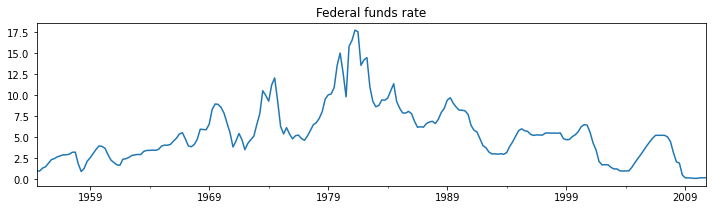

In [2]:

# Get the federal funds rate data
from statsmodels.tsa.regime_switching.tests.test_markov_regression import fedfunds
dta_fedfunds = pd.Series(fedfunds, index=pd.date_range('1954-07-01', '2010-10-01', freq='QS'))

# Plot the data
dta_fedfunds.plot(title='Federal funds rate', figsize=(12,3))

# Fit the model
# (a switching mean is the default of the MarkovRegession model)
mod_fedfunds = sm.tsa.MarkovRegression(dta_fedfunds, k_regimes=2)
res_fedfunds = mod_fedfunds.fit()
res_fedfunds.summary()

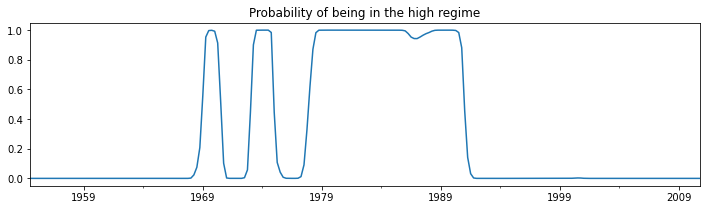

In [3]:
res_fedfunds.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high regime', figsize=(12,3));

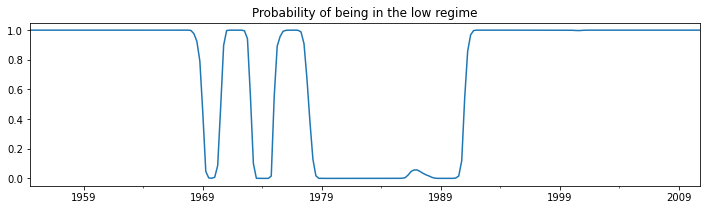

In [6]:
res_fedfunds.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the low regime', figsize=(12,3));

In [4]:
print(res_fedfunds.expected_durations)

[55.85400626 19.85506546]


# Federal funds rate with switching intercept and lagged dependent variable

The second example augments the previous model to include the lagged value of the federal funds rate.

In [8]:
# Fit the model
mod_fedfunds2 = sm.tsa.MarkovRegression(
    dta_fedfunds.iloc[1:], k_regimes=2, exog=dta_fedfunds.iloc[:-1])
res_fedfunds2 = mod_fedfunds2.fit()
res_fedfunds2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               MarkovRegression   Log Likelihood                -264.711
Date:                Thu, 17 Sep 2020   AIC                            543.421
Time:                        02:23:42   BIC                            567.334
Sample:                    10-01-1954   HQIC                           553.073
                         - 10-01-2010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7245      0.289      2.510      0.012       0.159       1.290
x1             0.7631      0.034     22.629      0.000       0.697       0.829
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0989      0.118     -0.835      0.404      -0.331       0.133
x1             1.0612      0.019     57.351      0.000       1.025       1.097
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4783      0.050      9.642      0.000       0.381       0.576
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.6378      0.120      5.304      0.000       0.402       0.874
p[1->0]        0.1306      0.050      2.634      0.008       0.033       0.228
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

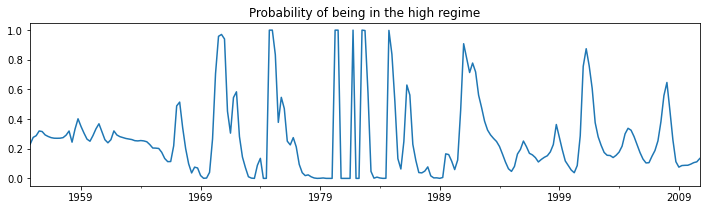

In [9]:
res_fedfunds2.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the high regime', figsize=(12,3));

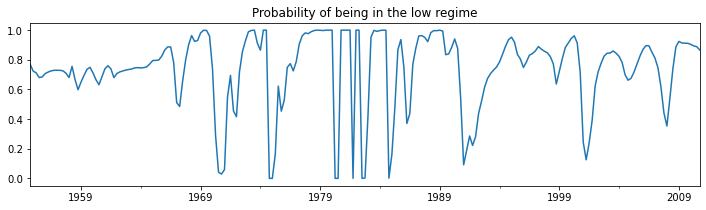

In [10]:
res_fedfunds2.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the low regime', figsize=(12,3));

In [11]:
print(res_fedfunds2.expected_durations)

[2.76105188 7.65529154]


# We now include two additional exogenous variables - a measure of the output gap and a measure of inflation - testing both 2 and 3 regimes to see which fits the data better.

Because the models can be often difficult to estimate, for the 3-regime model we employ a search over starting parameters to improve results, specifying 20 random search repetitions.

In [13]:
# Get the additional data
from statsmodels.tsa.regime_switching.tests.test_markov_regression import ogap, inf
dta_ogap = pd.Series(ogap, index=pd.date_range('1954-07-01', '2010-10-01', freq='QS'))
dta_inf = pd.Series(inf, index=pd.date_range('1954-07-01', '2010-10-01', freq='QS'))

exog = pd.concat((dta_fedfunds.shift(), dta_ogap, dta_inf), axis=1).iloc[4:]

# Fit the 2-regime model
mod_fedfunds3 = sm.tsa.MarkovRegression(
    dta_fedfunds.iloc[4:], k_regimes=2, exog=exog)
res_fedfunds3 = mod_fedfunds3.fit()

# Fit the 3-regime model
np.random.seed(12345)
mod_fedfunds4 = sm.tsa.MarkovRegression(
    dta_fedfunds.iloc[4:], k_regimes=3, exog=exog)
res_fedfunds4 = mod_fedfunds4.fit(search_reps=20)

In [14]:
res_fedfunds4.summary()

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               MarkovRegression   Log Likelihood                -180.806
Date:                Thu, 17 Sep 2020   AIC                            399.611
Time:                        02:26:07   BIC                            464.262
Sample:                    07-01-1955   HQIC                           425.713
                         - 10-01-2010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0250      0.290     -3.531      0.000      -1.594      -0.456
x1             0.3277      0.086      3.812      0.000       0.159       0.496
x2             0.2036      0.049      4.152      0.000       0.107       0.300
x3             1.1381      0.081     13.977      0.000       0.978       1.298
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0259      0.087     -0.298      0.765      -0.196       0.144
x1             0.9737      0.019     50.265      0.000       0.936       1.012
x2             0.0341      0.017      2.030      0.042       0.001       0.067
x3             0.1215      0.022      5.606      0.000       0.079       0.164
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7346      0.130      5.632      0.000       0.479       0.990
x1             0.8436      0.024     35.198      0.000       0.797       0.891
x2             0.1633      0.025      6.515      0.000       0.114       0.212
x3            -0.0499      0.027     -1.835      0.067      -0.103       0.003
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1660      0.018      9.240      0.000       0.131       0.201
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7214      0.117      6.177      0.000       0.493       0.950
p[1->0]     4.001e-08        nan        nan        nan         nan         nan
p[2->0]        0.0783      0.038      2.079      0.038       0.004       0.152
p[0->1]        0.1044      0.095      1.103      0.270      -0.081       0.290
p[1->1]        0.8259      0.054     15.208      0.000       0.719       0.932
p[2->1]        0.2288      0.073      3.150      0.002       0.086       0.371
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differ

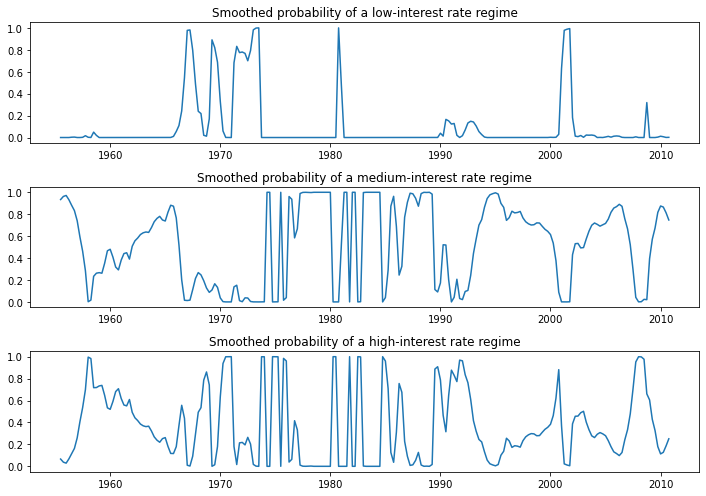

In [15]:
fig, axes = plt.subplots(3, figsize=(10,7))

ax = axes[0]
ax.plot(res_fedfunds4.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-interest rate regime')

ax = axes[1]
ax.plot(res_fedfunds4.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-interest rate regime')

ax = axes[2]
ax.plot(res_fedfunds4.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-interest rate regime')

fig.tight_layout()

# Switching Variances



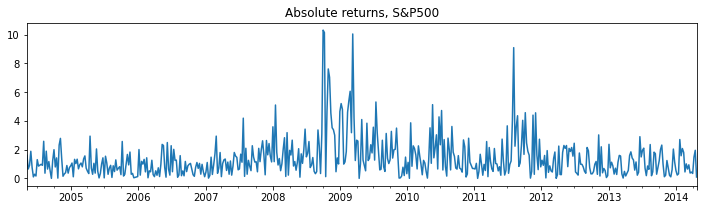

In [21]:
# Get the federal funds rate data
from statsmodels.tsa.regime_switching.tests.test_markov_regression import areturns
dta_areturns = pd.Series(areturns, index=pd.date_range('2004-05-04', '2014-5-03', freq='W'))

# Plot the data
dta_areturns.plot(title='Absolute returns, S&P500', figsize=(12,3))

# Fit the model
mod_areturns = sm.tsa.MarkovRegression(
    dta_areturns.iloc[1:], k_regimes=2, exog=dta_areturns.iloc[:-1], switching_variance=True)
res_areturns = mod_areturns.fit()

In [22]:
res_areturns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  520
Model:               MarkovRegression   Log Likelihood                -745.798
Date:                Thu, 17 Sep 2020   AIC                           1507.595
Time:                        02:27:19   BIC                           1541.626
Sample:                    05-16-2004   HQIC                          1520.926
                         - 04-27-2014                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7641      0.078      9.761      0.000       0.611       0.918
x1             0.0791      0.030      2.620      0.009       0.020       0.138
sigma2         0.3476      0.061      5.694      0.000       0.228       0.467
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9728      0.278      7.086      0.000       1.427       2.518
x1             0.5280      0.086      6.155      0.000       0.360       0.696
sigma2         2.5771      0.405      6.357      0.000       1.783       3.372
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7531      0.063     11.871      0.000       0.629       0.877
p[1->0]        0.6825      0.066     10.301      0.000       0.553       0.812
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

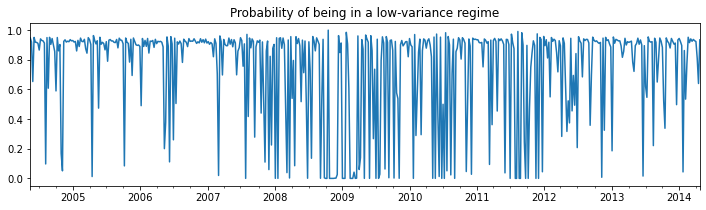

In [23]:
res_areturns.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in a low-variance regime', figsize=(12,3));

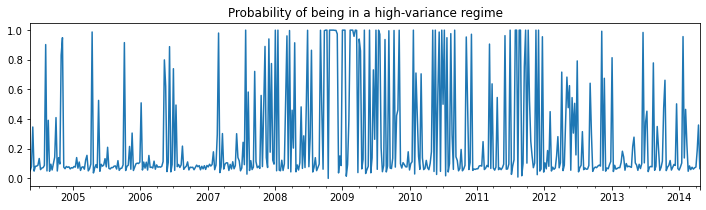

In [24]:
res_areturns.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in a high-variance regime', figsize=(12,3));